# RoBERTa.ipynb (Thesis by Friso Stolk)


# PACKAGES

In [ ]:
!pip install transformers
!pip install pytorch_lightning
from concurrent.futures import thread
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import pytorch_lightning as pl
import transformers
from transformers import RobertaConfig, RobertaModel, RobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 6.6 MB 41.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 5.4 MB/s 
     |████████████████████████████████| 140 kB 52.5 MB/s 
     |████████████████████████████████| 418 kB 51.4 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 
     |████████████████████████████████| 144 kB 45.5 MB/s 
     |████████████████████████████████| 271 kB 53.3 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 


# DATASET CLASS

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
class EvidenceTypeDataset(Dataset):

    def __init__(self, thread_id, sentence, target, tokenizer, max_len):
        self.thread_id = thread_id
        self.sentence = sentence
        self.targets = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, item):
        sentence = str(self.sentence[item])
        thread_id = str(self.thread_id[item])

        encoding = self.tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        return {
            'thread_id': thread_id,
            'sentence_text': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.targets[item], dtype=torch.long)
        }

Mounted at /content/gdrive


# MACHINE LEARNING CLASS

In [ ]:
class EvidenceTypeClassifier(nn.Module):

    def __init__(self, num_classes):
        super(EvidenceTypeClassifier, self).__init__()
        # defines model
        self.roberta = RobertaModel.from_pretrained('roberta-base', return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

# DATALOADER

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    # creates dataloader to return the right foramt
    return DataLoader(
        EvidenceTypeDataset(
            thread_id=df.thread_id.to_numpy(),
            sentence=df.sentence.to_numpy(),
            target=df.label.to_numpy(),
            tokenizer=tokenizer,
            max_len=max_len
        ),
        batch_size=batch_size,
        num_workers=4
    )

# MODEL TRAINER

In [ ]:
def train_model(model, data_loader, loss_function, optimizer, scheduler, num_examples):
    # Trains model
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / num_examples, np.mean(losses)

# EVALUATION OF MODEL

In [ ]:
def evaluate_model(model, data_loader, loss_function, num_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids']
            attention_mask = d['attention_mask']
            targets = d['targets']

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / num_examples, np.mean(losses)

# FIND BEST MODEL

In [ ]:
def find_best_model(model, loss_function, df_train, df_val, tokenizer, max_len, batch_size, num_epochs, print_graph=True, save_file_name='best_model_state.bin'):

    train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
    val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)

    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)

    total_steps = len(train_data_loader) * num_epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 40)

        training_accuracy, training_loss = train_model(
            model,
            train_data_loader,
            loss_function,
            optimizer,
            scheduler,
            len(df_train)
        )

        print('Training:   loss {:.3f} - accuracy {:.3f}'.format(training_loss, training_accuracy))

        validation_accuracy, validation_loss = evaluate_model(
            model,
            val_data_loader,
            loss_function,
            len(df_val)
        )

        print('Validation: loss {:.3f} - accuracy {:.3f}\n'.format(validation_loss, validation_accuracy))

        history['training_accuracy'].append(training_accuracy)
        history['training_loss'].append(training_loss)

        history['validation_accuracy'].append(validation_accuracy)
        history['validation_loss'].append(validation_loss)

        if validation_accuracy > best_accuracy:
            torch.save(model.state_dict(), save_file_name)
            best_accuracy = validation_accuracy
            with open('/content/gdrive/My Drive/best_model.bin', 'w') as f:
              torch.save(model.state_dict(), "/content/gdrive/My Drive/best_model.bin")

    if print_graph:
        plt.plot(history['training_accuracy'], label='training accuracy')
        plt.plot(history['validation_accuracy'], label='validation accuracy')
        plt.title('Training history')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.ylim([0, 1])
        plt.show()

# PREDICT LABELS

In [ ]:
def get_predictions(model, data_loader, label_encoder, save_predictions=True, save_file_name='predictions.csv'):
    model = model.eval()
    thread_id_list = []
    comment_id_list = []
    sentence_texts = []
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            thread_ids = d['thread_id']
            # comment_ids = d['comment_id']
            texts = d["sentence_text"]
            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            targets = d["targets"]
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            thread_id_list.extend(thread_ids)
            #comment_id_list.extend(comment_ids)
            sentence_texts.extend(texts)
            predictions.extend(preds)
            real_values.extend(targets)

    if save_predictions:
        df_pred = pd.DataFrame()
        df_pred['thread_id'] = thread_id_list
        # df_pred['comment_id'] = comment_id_list
        df_pred['sentence'] = sentence_texts
        df_pred['pred_label'] = label_encoder.inverse_transform(predictions)
        df_pred['real_label'] = label_encoder.inverse_transform(real_values)

        df_pred.to_csv(save_file_name, index=False)

    return thread_id_list, comment_id_list, sentence_texts, predictions, real_values

# PREPARE DATA

In [ ]:
# reads dataset and split it into train dev and test set
def prepare_data(dataset):
  # prepares data and shuffle it in 30 threads train 10 threads dev and 10 threads test
  dataset.head()
  thread_ids = dataset["thread_id"].unique()
  random.Random(10).shuffle(thread_ids)

  train_ids = thread_ids[:30]
  dev_ids = thread_ids[30:40]
  test_ids = thread_ids[40:50]

  train = dataset.loc[dataset["thread_id"].isin(train_ids)]
  test = dataset.loc[dataset["thread_id"].isin(test_ids)]
  dev = dataset.loc[dataset["thread_id"].isin(dev_ids)]
  return(train,test,dev)


In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

# MAIN FUNCTION

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the 

                  precision    recall  f1-score   support

        Anecdote       0.75      0.67      0.71       144
      Assumption       0.83      0.91      0.87       763
      Definition       0.00      0.00      0.00        30
            None       0.76      0.77      0.76       323
           Other       0.00      0.00      0.00        20
Statistics/Study       0.58      0.61      0.59        18
       Testimony       0.00      0.00      0.00        20

        accuracy                           0.80      1318
       macro avg       0.42      0.42      0.42      1318
    weighted avg       0.75      0.80      0.77      1318



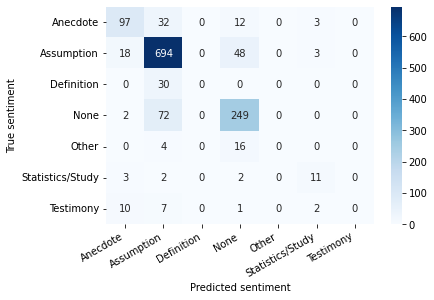

In [ ]:
def main():

    # reads dataset annotations
    df = pd.read_csv('final_dataset.csv')



    # Transform labels to integers
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['evidence_no_continue'])

    # define tokenizer
    from transformers import AutoTokenizer
    model_name = 'roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)


    #loss_function = SelfAdjDiceLoss()

    # gest split between train validation and test data
    df_train, df_val, df_test = prepare_data(df)
    #compute the class weights
    # class_weights = (1 - (df['label'].value_counts().sort_index() / len(df))).values
    # class_weights = torch.from_numpy(class_weights).float().to("cuda")
    # loss_function = nn.CrossEntropyLoss(weight=class_weights).to("cuda")
    # define loss function
    loss_function = nn.CrossEntropyLoss().to(device)

    # hyper parameters
    max_len = 100
    batch_size = 64
    num_epochs = 20

    # number of different labels
    num_classes = len(df['label'].unique())
    # creates right input
    test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)
    # Define model
    model = EvidenceTypeClassifier(num_classes)
    # finds the best model
    #find_best_model(model, loss_function, df_train, df_val, tokenizer, max_len, batch_size, num_epochs)

    # define best model
    model = EvidenceTypeClassifier(num_classes)
    model.load_state_dict(torch.load('roberta_model_state.bin'))
    model = model
    
    # gets predictions
    thread_ids, comment_ids, y_sentence_texts, y_pred, y_test = get_predictions(
    model,
    test_data_loader,
    label_encoder,
    save_file_name='predictions_annotated_roberta.csv'
    )

    # gets results
    y_test = label_encoder.inverse_transform(y_test)
    y_pred = label_encoder.inverse_transform(y_pred)

    # print (classification report)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['Anecdote', 'Assumption', 'Definition', 'None', 'Other', 'Statistics/Study', 'Testimony']
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    show_confusion_matrix(df_cm)
    

    # predict unannotated sentences
    # df_unpredicted = pd.read_csv("unannotated_sentences.csv")
    # df_unpredicted["label"] = 0
    # df_unpredicted["comment_id"] = 0
    # unpredicted_data_loader = create_data_loader(df_unpredicted, tokenizer, max_len, batch_size)
    # thread_ids, comment_ids, y_sentence_texts, y_pred, y_test = get_predictions(
    #   model,
    #   unpredicted_data_loader,
    #   label_encoder,
    #   save_file_name='predictions.csv'
    # )






if __name__ == '__main__':
    main()